In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon

# normalizar
import numpy as np
from shapely.geometry import mapping
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# gerar e visualizar csv
import csv
import pandas as pd

# Roteiro

**O objetivo desse notebook é criar 2 datasets: o de prédios da Unicamp e o de posicionamento dos coletores no Campus.** Para isso, as seguintes etapas foram seguidas:

- Extração de shapes e plots da Unicamp
- Conversão de CRS
- Normalização de Mapa da Unicamp
- Criação de dataset dos Prédios da Unicamp
- Criação de dataset do posicionamento dos Coletores
- Tramento de Dados Faltantes

**Os datasets gerados serão utilizados como entradas para as simulações LoRaWAN feitas no simulador NS3**

# Extração de shapes e Plots da Unicamp

- Extração de região geográfica de interesse (bbbike) no formato .shp
- Plot de shapes

In [2]:
# Apontando para o path do dataset da Unicamp
import os

current_path = os.getcwd()
# print(current_path.find('obstacle_exp'))
# print(current_path[0:current_path.find('obstacle_exp')])

map_dataset_path = current_path[:current_path.find('obstacle_exp')]
building_shp_path = "unicamp-shapefiles-dataset/shape/buildings.shp"
roads_shp_path = "unicamp-shapefiles-dataset/shape/roads.shp"

unicamp_building_dataset_path = map_dataset_path + building_shp_path
unicamp_roads_dataset_path = map_dataset_path + roads_shp_path

In [3]:
# ----- READ BUILDING SHAPES DATASET

# use bbbike to obtain shape files
# bbbike: https://extract.bbbike.org/

# Unicamp Shapes:
# landuse
# natural
# places
# points
# railways
# roads
# waterways
# buildings

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_roads_df = gpd.read_file(unicamp_roads_dataset_path)

print('shape:', unicamp_df.shape)
unicamp_df.head()

shape: (509, 4)


,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."


In [4]:
# ----- CHECK BUILDING SHAPES DATASET CRS

# crs - sistema referência de coordenadas

# WGS 84 - sistema de coords mundial (degree)
unicamp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

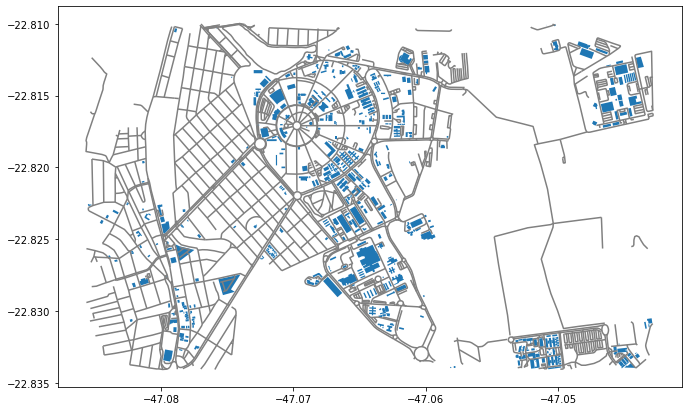

In [378]:
# ----- Plot UNICAMP MAPA (WGS84)
ax = unicamp_df.plot(figsize=(15, 7))
unicamp_roads_df.plot(ax=ax, figsize=(15, 7), color='gray')

,osm_id,name,type,geometry
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."


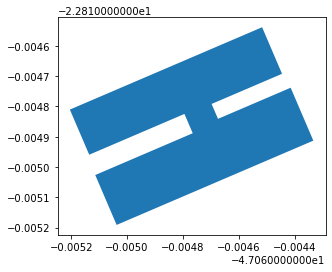

In [6]:
# ----- PLOT IC BUILDING (WGS84)
ic_predio = unicamp_df.query('osm_id == 95011169')
ax = ic_predio.plot()
ic_predio.head()

# Conversão de CRS

Conversão de CRS WGS 84 para SIRGAS 2000 / UTM zone 23S , que é dado em metros e representa o sistemas de georeferência das Américas.

Características:

- Datum: SIRGAS 2000
- Projeção: UTM zone 23S (Campinas/SP)
- América Latina
- Hemisfério sul. 

Referências:
- https://epsg.io/31981
- https://spatialreference.org/ref/?search=31981
- https://pt.slideshare.net/JorgeSantos30/20141011-qgis24-sistemadereferenciadecoordenadas
- https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
- https://cursos.alura.com.br/forum/topico-erro-ao-reprojetar-usando-a-funcao-to_crs-77139


In [7]:
# Geodataframe dos Prédios da Unicamp
unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_df.head(10)

,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."
5,95011175,DAC - Diretoria Acadêmica do Campus,university,"POLYGON ((-47.07073 -22.81754, -47.07051 -22.8..."
6,95463718,Restaurante Universitário,restaurant,"POLYGON ((-47.07236 -22.81793, -47.07183 -22.8..."
7,95463720,GMU - Ginásio Multidisciplinar,university,"POLYGON ((-47.07183 -22.81502, -47.07153 -22.8..."
8,95463721,None,None,"POLYGON ((-47.06819 -22.81501, -47.06789 -22.8..."
9,95463722,Instituto de Filosofia e Ciencias Humanas,university,"POLYGON ((-47.06806 -22.81536, -47.06853 -22.8..."


In [8]:
# Conversão de WSG84 para SIRGAS 2000 / UTM one 23S : 31983
# Zona 23 inclui Campinas
# https://spatialreference.org/ref/epsg/31983/

unicamp_utm_df = unicamp_df.to_crs(31983)
unicamp_utm_df.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((288179.970 7475626.000, 288182.081 7..."
1,95011157,Banco Santander,bank,"POLYGON ((287668.651 7475263.188, 287667.599 7..."
2,95011161,Ciclo Básico II,university,"POLYGON ((287476.147 7475140.737, 287495.256 7..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((288034.700 7475498.723, 288104.976 7..."
4,95011172,IC 3.5,university,"POLYGON ((288134.073 7475638.141, 288139.036 7..."
5,95011175,DAC - Diretoria Acadêmica do Campus,university,"POLYGON ((287471.903 7475188.530, 287494.612 7..."
6,95463718,Restaurante Universitário,restaurant,"POLYGON ((287305.221 7475143.279, 287359.092 7..."
7,95463720,GMU - Ginásio Multidisciplinar,university,"POLYGON ((287355.264 7475465.824, 287386.481 7..."
8,95463721,None,None,"POLYGON ((287728.526 7475472.273, 287759.847 7..."
9,95463722,Instituto de Filosofia e Ciencias Humanas,university,"POLYGON ((287742.863 7475434.026, 287693.507 7..."


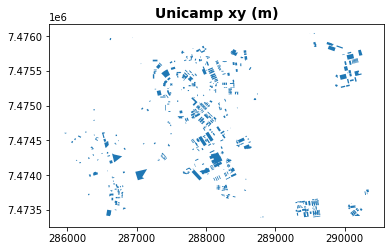

In [9]:
# Plot de mapa Convertido para SIRGAS 2000 / UTM zone 23S
ax = unicamp_utm_df.plot()
plt.title('Unicamp xy (m)',fontweight='bold',fontsize=14)

# Dataframe convertido
unicamp_utm_df.head(10)

In [10]:
unicamp_utm_df['centroids'] = unicamp_utm_df.centroid
unicamp_utm_df['centroids']

0      POINT (288164.757 7475614.484)
1      POINT (287680.703 7475257.946)
2      POINT (287463.109 7475182.762)
3      POINT (288079.758 7475493.426)
4      POINT (288158.099 7475640.063)
                    ...              
504    POINT (288473.227 7474421.359)
505    POINT (288491.927 7474443.209)
506    POINT (286688.852 7474451.339)
507    POINT (286696.551 7474453.636)
508    POINT (289447.856 7473449.118)
Name: centroids, Length: 509, dtype: geometry

In [11]:
unicamp_utm_df.head()

,osm_id,name,type,geometry,centroids
0,95011154,IC 3,university,"POLYGON ((288179.970 7475626.000, 288182.081 7...",POINT (288164.757 7475614.484)
1,95011157,Banco Santander,bank,"POLYGON ((287668.651 7475263.188, 287667.599 7...",POINT (287680.703 7475257.946)
2,95011161,Ciclo Básico II,university,"POLYGON ((287476.147 7475140.737, 287495.256 7...",POINT (287463.109 7475182.762)
3,95011169,IC - Instituto de Computação,university,"POLYGON ((288034.700 7475498.723, 288104.976 7...",POINT (288079.758 7475493.426)
4,95011172,IC 3.5,university,"POLYGON ((288134.073 7475638.141, 288139.036 7...",POINT (288158.099 7475640.063)


# Normalização de Mapa da Unicamp

In [12]:
# Bounds of Unicamp Map
unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy = unicamp_utm_df.geometry.total_bounds

print('bounds:', unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
print('x:', unicamp_maxx-unicamp_minx)
print('y:', unicamp_maxy- unicamp_miny)


bounds: 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
x: 4387.848261102627
y: 2661.465870924294


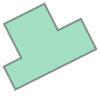

In [13]:
# get all geometries of unicamp_utm_df
unicamp_geometries = [i for i in unicamp_utm_df.geometry]

# geometry example
unicamp_geometries[0]

In [343]:
map_minx = 1e+10
map_maxx = -1
map_miny = 1e+10
map_maxy = -1

for geometry in range(len(unicamp_geometries)):
    
    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 

    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # get all geometry coords in x and y
    if geometry == 0:
        all_coords_x = x_coords.copy()
        all_coords_y = y_coords.copy()
    else:
        all_coords_x = np.append (all_coords_x, x_coords.copy(), axis=0)
        all_coords_y = np.append (all_coords_y, y_coords.copy(), axis=0)
        
    # get bounds limits of map and compare with unicamp_utm_df.geometry.total_bounds
    # after for loop, limits must be equal
    if np.min(x_coords) < map_minx:
        map_minx = np.min(x_coords)
    if np.max(x_coords) > map_maxx:
        map_maxx = np.max(x_coords)
    
    if np.min(y_coords) < map_miny:
        map_miny = np.min(y_coords)
    if np.max(y_coords) > map_maxy:
        map_maxy = np.max(y_coords)
    

# after for loop, limits must be equal
print(map_minx, map_miny,map_maxx, map_maxy)
print(unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
# yey

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968


In [15]:
# create a normalized map with unicamp bounds

# criando novo mapa, que conterá geometrias normalizadas
mapa_normalizado = gpd.GeoDataFrame(columns=["geometry"])
mapa_normalizado['osm_id'] = unicamp_utm_df['osm_id']
mapa_normalizado['name'] = unicamp_utm_df['name']
mapa_normalizado['type'] = unicamp_utm_df['type']

# processo de normalização
for geometry in range(len(unicamp_geometries)):

    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 
    
    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords).reshape(-1, 1) 
    y_coords = np.array(y_coords).reshape(-1, 1)
    
    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))
    
    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)
    
    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)
    
    # convert np array x and y normalized back to polygon
    building_geometry = np.append (transform_x, transform_y, axis=1)
    new_polygon = Polygon(building_geometry)
    
    mapa_normalizado.loc[geometry, 'geometry'] = new_polygon
    

print('Shape do Mapa normalizado:', mapa_normalizado.shape)
mapa_normalizado.head()

Shape do Mapa normalizado: (509, 4)


,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


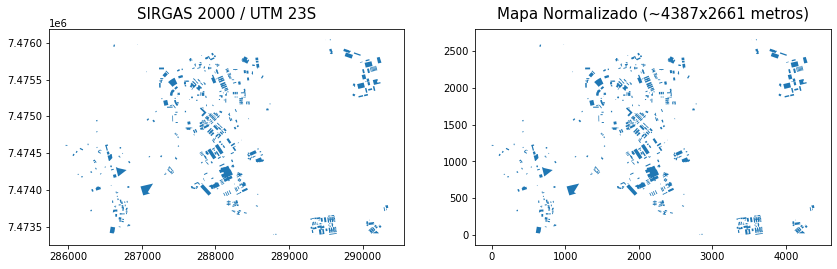

In [16]:
# ANTES E DEPOIS DA NORMALIZAÇÃO

fig, axes = plt.subplots(1,2, figsize = (14, 7)) # 1 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('SIRGAS 2000 / UTM 23S', fontsize=15, y=1.02)
unicamp_utm_df.plot(ax=axes[0])

# Mapa da Unicamp
# onde:
# - unicamp bounds = 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
# - maxx - minx    = 4387.848261102627
# - maxy - miny    = 2661.465870924294
axes[1].set_title('Mapa Normalizado (~4387x2661 metros)', fontsize=15, y=1.02)
mapa_normalizado.plot(ax=axes[1])

plt.show()

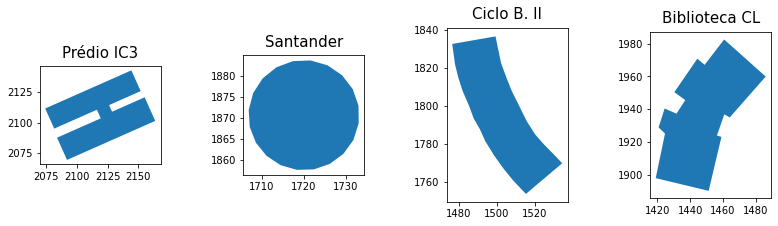

In [17]:
# EXEMPLO DE PRÉDIOS NORMALIZADOS

# get buildings
ic_predio = mapa_normalizado.query('osm_id == 95011169')
santander = mapa_normalizado.query('osm_id == 95011157')
cbII_predio = mapa_normalizado.query('osm_id == 95011161')
biblioteca = mapa_normalizado.query('osm_id == 95463723')

# plot buildings
fig, axes = plt.subplots(1,4, figsize = (12, 5)) # 2 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('Prédio IC3', fontsize=15, y=1.02)
ic_predio.plot(ax=axes[0])

axes[1].set_title('Santander', fontsize=15, y=1.02)
santander.plot(ax=axes[1])

axes[2].set_title('Ciclo B. II', fontsize=15, y=1.02)
cbII_predio.plot(ax=axes[2])

axes[3].set_title('Biblioteca CL', fontsize=15, y=1.02)
biblioteca.plot(ax=axes[3])

# space between subplots
fig.tight_layout(pad=5.0)

plt.show()

# Google Maps: https://www.google.com/maps/place/Coordenadoria+de+P%C3%B3s-gradua%C3%A7%C3%A3o+-+Instituto+de+Biologia+%2F+Unicamp/@-22.8174874,-47.069779,253m/data=!3m1!1e3!4m5!3m4!1s0x0:0x5970884374643347!8m2!3d-22.8194777!4d-47.0698417

# Criação de dataset dos Prédios da Unicamp

- Create a xml file with Unicamp Building shapes & height
- The outuput xml file will serve as input of NS3

In [18]:
mapa_normalizado

,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university
...,...,...,...,...
504,"POLYGON ((2500.518 1026.088, 2506.724 1013.990...",698317159,Nudecri / Labeurb,university
505,"POLYGON ((2522.389 1058.417, 2528.388 1047.944...",698317160,None,university
506,"POLYGON ((718.297 1071.341, 734.090 1053.031, ...",747442133,O Funcional,None
507,"POLYGON ((722.538 1074.934, 729.239 1081.088, ...",747442134,Jardim Aéreo,None


In [19]:
# estudando e tratando a string Polygon

polygon_str = str(mapa_normalizado['geometry'][0])
polygon_coords = polygon_str[polygon_str.find("(") + 2:]
polygon_coords = polygon_coords[ : polygon_coords.find(")")]
polygon_coords

'2219.251139687083 2238.727775357664, 2221.361987684679 2239.787423081696, 2228.596089881903 2225.477409613319, 2190.487653719552 2206.424288934097, 2184.996146517573 2217.280481930822, 2193.215351607127 2221.394112979993, 2185.146765219572 2237.365068141371, 2204.206298525154 2246.880641972646, 2210.521516594803 2234.396566327661, 2214.620936836873 2236.447694022208, 2219.251139687083 2238.727775357664'

In [20]:
# Criando xml dataset
from xml.dom import minidom
import os 
  
root = minidom.Document()
  
xml = root.createElement('additional') 
xml.setAttribute('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xml.setAttribute('xsi:noNamespaceSchemaLocation','http://sumo.dlr.de/xsd/additional_file.xsd')
root.appendChild(xml)

for i in range(len(mapa_normalizado['geometry'])):   
    
    polygon_str = str(mapa_normalizado['geometry'][i])
    polygon_coords = polygon_str[polygon_str.find("(") + 2:]
    polygon_coords = polygon_coords[ : polygon_coords.find(")")]
    
    productChild = root.createElement('poly')
    productChild.setAttribute('id', str(mapa_normalizado['osm_id'][i]))
    productChild.setAttribute('type', str(mapa_normalizado['type'][i]))
    productChild.setAttribute('color', '255.0,230.0,230.0')
    productChild.setAttribute('layer', '-1.0')
    productChild.setAttribute('fill', '1')
    productChild.setAttribute('height', '6.1')
    productChild.setAttribute('shape', polygon_coords)
  
    xml.appendChild(productChild)
  
xml_str = root.toprettyxml(indent ="\t") 
  
save_path_file = "predios_unicamp_dataset.xml"
  
with open(save_path_file, "w") as f:
    f.write(xml_str) 
    

# Criação de dataset do posicionamento dos Coletores

- Mapear predios que contem coletores
    - https://www.prefeitura.unicamp.br/2016/02/26/programa-de-coleta-de-pilhas-e-baterias-instalacao-de-coletores/
    - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

- Anotar centroids de prédios mapeados

- Montar csv de posicionamento de nós

In [21]:
# ----- RESULTADOS DO MAPEAMENTO

# ENCONTRADOS POR CONSULTA DE NOME:
# 1. Agência de Inovação Inova Unicamp (INOVA) # 163762428
# 2. Biblioteca Central (BC) # 95463723
# 11. Ciclo Básico II # 95011161
# 14. Diretoria Geral de Recursos Humanos (DGRH) # 362643631
# 18. Faculdade de Ciências Médicas (FCM) # 537142892
# 24. Faculdade de Engenharia Elétrica e de Computação (FEEC) # 269851018
# 25. Faculdade de Engenharia Mecânica (FEM) # 554951124
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # 556327623
# 32. Instituto de Biologia (IB) # 95540601
# 33. Instituto de Computação (IC) # 95011169
# 35. Instituto de Filosofia e Ciências Humanas (IFCH) # 95463722
# 39. Instituto de Matemática, Estatística e Computação Científica (IMECC) # 95463724
# 41. Prefeitura Universitária # 562047775
# 45. Restaurante Administrativo (RA) # 269851019
# 46. Restaurante Saturnino (RS) # 270488633
# 47. Restaurante Universitário (RU) # 95463718


# ENCONTRADOS POR CONSULTA DE TIPO:

# 4. Centro de Componentes Semicondutores (CCS) # 554951142
# 6. Centro de Diagnóstico de Doenças do Aparelho Digestivo (GASTROCENTRO) # 556327645 e 556327646
# 8. Centro de Hematologia e Hemoterapia (HEMOCENTRO) # 556327636
# 9. Centro para Manutenção de Equipamentos (CEMEQ) # 556327686
# 12. Coordenadoria de Desenvolvimento Cultural (CDC) # 95463720
# 13. Diretoria Geral da Administração (DGA) # 554951141
# 15. Divisão de Educação Infantil e Complementar (DEdIC) # 537155702
# 16. Engenharia Básica (EB)  # 554951142 (ccs)
# 20. Faculdade de Enfermagem (FEnf) # 537142893
# 21. Faculdade de Engenharia Agrícola (FEAGRI) # 97592693 ~
# 23. Faculdade de Engenharia de Alimentos (FEA) # 554951120 ~
# 26. Faculdade de Engenharia Química (FEQ) # 554968138
# 28. Gabinete do Reitor (GR) # 562047779
# 34. Instituto de Estudos da Linguagem (IEL) # 556327698 ~
# 40. Instituto de Química (IQ) # 96493946


# ENCONTRADOS POR SHAPES:

# 19. Faculdade de Educação Física (FEF) # 96446654
# 22. Faculdade de Engenharia Civil, Arquitetura e Urbanismo (FEC) # 556327678
# 30. Hospital de Clínicas (HC) # 538334949
# 31. Instituto de Artes (IA) # 537166697
# 36. Instituto de Física Gleb Wataghin (IFGW) # 556327703
# 37. Instituto de Geociências (IG) da Rua Oswaldo Cruz -------------
# 38. Instituto de Geociências (IG) da Avenida Érico Veríssimo -------------


# NÃO ESTÃO NO MAPA (DADOS FALTANTES - 9):

# 3. Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
# 5. Centro de Computação (CCUEC) 
# 7. Centro de Estudos de Petróleo (CEPETRO) 
# 10. Ciclo Básico I 
# 17. Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
# 29. Grupo Gestor de Obras (GGO) 

# Casos especiais:
# 42. Ponto de ônibus – Rua Roxo Moreira (PO-RM)
# 43. Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
# 44. Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [379]:
# ----- METÓDOS DE BUSCA PARA MAPEAMENTO

# Busca por linha em todo dataset
predio = mapa_normalizado.iloc[76:77] # ex Reitoria 367-376
predio.head()


# Busca por Nome
# predio = mapa_normalizado[mapa_normalizado['name'].str.contains("Restaurante",  na=False)]
# predio.head()

# Busca de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao
# predio.head()

# Busca por linhas de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao.iloc[47:48] # ex HC
# predio.head()

,geometry,osm_id,name,type
76,"POLYGON ((2679.359 2170.779, 2693.756 2162.661...",386834061,Núcleo do Parque Científico e Tecnológico da,university


(0.0, 2661.465870924294)

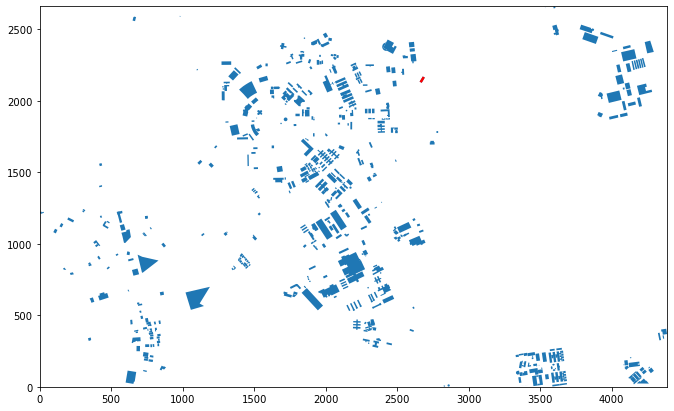

In [381]:
# ----- PLOT DE PREDIO DE ACORDO COM A BUSCA REALIZADA

ax = mapa_normalizado.plot(figsize=(15, 7))

# predios None
predio['geometry'].plot(ax=ax, color='Red')

# Para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [24]:
# Dataset de Prédio com coletores

unlabeled_buildings = {
    "163762428":"INOVA",
    "95463723": "BC",
    "95011161": "CBII",
    "362643631": "DGRH",
    "537142892": "FCM",
    "269851018": "FEEC",
    "554951124": "FEM",
    "556327623": "FUNCAMP",
    "95540601": "IB",
    "95011169": "IC",
    "95463722": "IFCH",
    "95463724": "IMECC",
    "562047775": "PREFEITURA",
    "269851019": "RA",
    "270488633": "RS",
    "95463718": "RU",
    "554951142": "CCS",
    "556327645": "GASTROCENTRO",
    "556327636": "HEMOCENTRO",
    "556327686": "CEMEQ",
    "95463720": "CDC",
    "554951141": "DGA",
    "537155702": "DEdIC",
    "537142893": "FEnf",
    "97592693": "FEAGRI",
    "554951120": "FEA",
    "554968138": "FEQ",
    "562047779": "GR",
    "556327698": "IEL",
    "96493946": "IQ"
}


nodes_df = gpd.GeoDataFrame(columns=['osm_id', 'name', 'type', 'geometry', 'centroid'])

# Labeling buildings
aux = 0
for key, value in unlabeled_buildings.items():
    building = mapa_normalizado.query('osm_id ==' + str(key))
    building_n = building.copy()
    building_n.loc[building.index, 'name'] = value
    nodes_df.loc[aux, ['osm_id']] = building_n['osm_id'].values   
    nodes_df.loc[aux, ['name']] = building_n['name'].values    
    nodes_df.loc[aux, ['type']] = building_n['type'].values
    nodes_df.loc[aux, ['geometry']] = building_n['geometry'].values
#     nodes_df.loc[aux, ['centroids']] = building_n['centroids'].values
    
    aux = aux + 1
    
nodes_df.head()
# nodes_df.shape


,osm_id,name,type,geometry,centroid
0,163762428,INOVA,None,"POLYGON ((2537.468 2317.065, 2557.548 2318.984...",NaN
1,95463723,BC,library,"POLYGON ((1418.961 1897.896, 1451.293 1890.141...",NaN
2,95011161,CBII,university,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",NaN
3,362643631,DGRH,university,"POLYGON ((1831.657 1098.749, 1867.128 1121.798...",NaN
4,537142892,FCM,university,"POLYGON ((2215.365 470.838, 2214.982 459.301, ...",NaN


In [25]:
nodes_df['centroid'] = nodes_df.centroid
nodes_df.head()

,osm_id,name,type,geometry,centroid
0,163762428,INOVA,None,"POLYGON ((2537.468 2317.065, 2557.548 2318.984...",POINT (2555.945 2307.239)
1,95463723,BC,library,"POLYGON ((1418.961 1897.896, 1451.293 1890.141...",POINT (1448.467 1935.840)
2,95011161,CBII,university,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",POINT (1502.390 1795.490)
3,362643631,DGRH,university,"POLYGON ((1831.657 1098.749, 1867.128 1121.798...",POINT (1852.204 1105.999)
4,537142892,FCM,university,"POLYGON ((2215.365 470.838, 2214.982 459.301, ...",POINT (2218.705 433.359)


<AxesSubplot:>

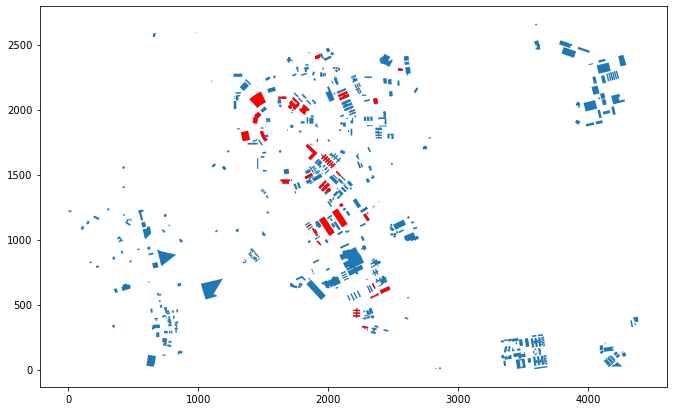

In [26]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# predios com coletores
nodes_df['geometry'].plot(ax=ax, color="red")

<AxesSubplot:>

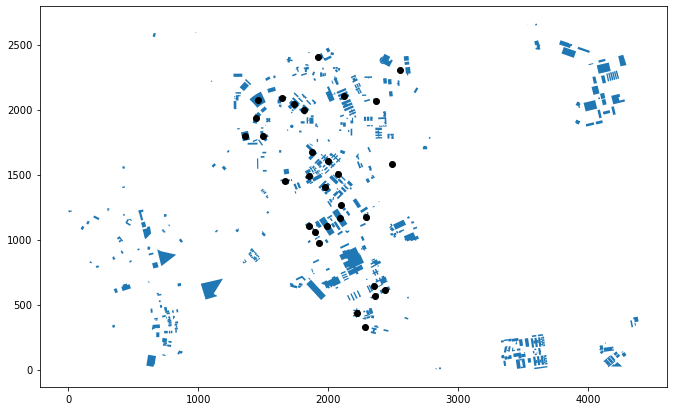

In [27]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")

In [28]:
# GENERATE BUILDINGS CSV FILE

colunms_names  = ['osm_id', 'name', 'type', 'x', 'y', 'z']


#---- create a csv file
def create_csv(title, colunms_names):
    with open(title,"w+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(colunms_names)


#---- add row on csv file
def add_csv_rows(ns3_settings, colunms_names, title):
    for colunm in ns3_settings:
        if len(colunm) == len(colunms_names):
            with open(title,"a") as file:
                writer = csv.writer(file, delimiter=",")
                writer.writerow([x for x in colunm])


In [29]:
nodes_pos = []
for i in range(len(nodes_df.geometry)):
    # tratando a string Point
    point_str = str(nodes_df['centroid'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [nodes_df.loc[i]['osm_id'],
              nodes_df.loc[i]['name'],
              nodes_df.loc[i]['type'],
              x, y, z]
    
    nodes_pos.append(items_per_row)

output_filename = 'coletores_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [30]:
node_pos_df = pd.read_csv("coletores_pos_dataset.csv") 

print("DATASET SHAPE:", node_pos_df.shape)
node_pos_df.head()

DATASET SHAPE: (30, 6)


,osm_id,name,type,x,y,z
0,163762428,INOVA,NaN,2555.945455,2307.239101,1.5
1,95463723,BC,library,1448.467151,1935.840334,1.5
2,95011161,CBII,university,1502.390006,1795.489976,1.5
3,362643631,DGRH,university,1852.204178,1105.998668,1.5
4,537142892,FCM,university,2218.705402,433.358880,1.5


# Tratamento de Dados Faltantes

- **[OK]** Museu
- IG (parte superior do mapa)
- IG (parte inferior do mapa)
- Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
- Centro de Computação (CCUEC) 
- Centro de Estudos de Petróleo (CEPETRO) 
- Ciclo Básico I 
- Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
- Grupo Gestor de Obras (GGO) 
- **[OK]** Ponto de ônibus – Rua Roxo Moreira (PO-RM)
- **[OK]** Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
- **[OK]** Ponto de ônibus – Rua Vital Brasil (PO-VB)

## Museu

In [315]:
# ----- CRIANDO SHAPE DO MUSEU
from shapely.geometry import Point

circle = Point(2873, 2125).buffer(16.45)  # type(circle) = polygon

print("Area:", circle.area)
print("Length:", circle.length)

Area: 848.7578629129567
Length: 103.31689506381134


(2050.0, 2200.0)

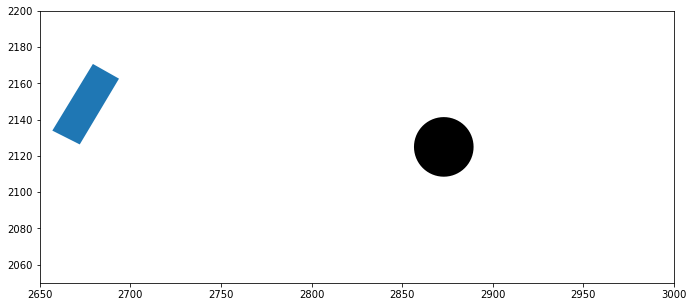

In [317]:
# -----PLOT DE MAPA NORMALIZADO E SHAPE DO MUSEU

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
circle_df = gpd.GeoDataFrame(columns=["geometry"])
circle_df.loc[0, 'geometry'] = circle
circle_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2650, 3000)
ax.set_ylim(2050, 2200)

In [313]:
# ----- Criação de Geodataframe para o calculo de distancia entre centroids do Museu e predio de referência (Inova)
points_df = gpd.GeoDataFrame(columns=["geometry"])
points_df.loc[:, 'geometry'] = mapa_normalizado.query('osm_id ==' + str(386834061))['geometry'] # invova
points_df.loc[0, 'geometry'] = circle

points_df['centroid'] = points_df["geometry"].centroid
points_df

,geometry,centroid
76,"POLYGON ((2679.359 2170.779, 2693.756 2162.661...",POINT (2675.485 2148.395)
0,"POLYGON ((2889.450 2125.000, 2889.371 2123.388...",POINT (2873.000 2125.000)


In [314]:
# Cálculo de Distância
points_df.distance(circle.centroid)

76    183.157318
0       0.000000
dtype: float64

## Paradas de Ônibus

In [355]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
# Google Maps ajuda nessa parte tb

parada_RM = Point(-47.0677, -22.8242) 
parada_AL = Point(-47.0629, -22.8319) 
parada_VB = Point(-47.0628, -22.8275)

# Convertendo Coordenadas em Degree para metros (31983)
pontos_onibus_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
pontos_onibus_df.loc[0, 'geometry'] = parada_RM
pontos_onibus_df.loc[1, 'geometry'] = parada_AL
pontos_onibus_df.loc[2, 'geometry'] = parada_VB
pontos_onibus_df = pontos_onibus_df.to_crs('EPSG:31983')
# pontos_onibus_df.crs
pontos_onibus_df


,geometry
0,POINT (287793.104 7474455.271)
1,POINT (288297.792 7473609.406)
2,POINT (288301.248 7474096.840)


In [357]:
# PONTOS no CRS EPSG:31983
parada_RM = Point(pontos_onibus_df['geometry'][0])
parada_AL = Point(pontos_onibus_df['geometry'][1])
parada_VB = Point(pontos_onibus_df['geometry'][2])

print(parada_RM)
print(parada_AL)
print(parada_VB)

POINT (287793.1041268592 7474455.270733602)
POINT (288297.7924639747 7473609.405694909)
POINT (288301.2480990409 7474096.839670669)


In [360]:
# NORMALIZAÇÃO DE PONTOS 

points = [parada_RM, parada_AL, parada_VB]
norm_points = []
for coords in points:
    
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1) 
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

    print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

[[1832.38494007]] [[1067.99849656]]
[[2337.07327719]] [[222.13345787]]
[[2340.52891225]] [[709.56743363]]
POINT (1832.384940070857 1067.998496558517)


In [373]:
#
pontos_onibus_norm_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pontos_onibus_norm_df.loc[0, 'geometry'] = norm_points[0]
pontos_onibus_norm_df.loc[1, 'geometry'] = norm_points[1]
pontos_onibus_norm_df.loc[2, 'geometry'] = norm_points[2]

pontos_onibus_norm_df

,geometry
0,POINT (1832.385 1067.998)
1,POINT (2337.073 222.133)
2,POINT (2340.529 709.567)


<AxesSubplot:>

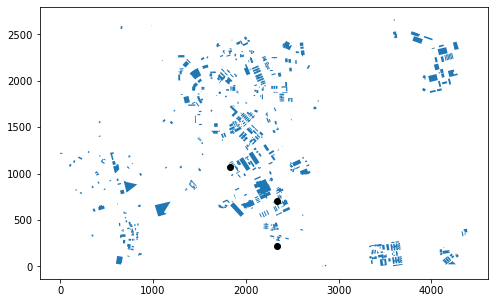

In [375]:
# Plot de paradas de ÔNIBUS
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pontos_onibus_norm_df.plot(ax=ax, color="black")